In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from datetime import datetime

def load_stock_data(filename):
    # Load dataset (tab-separated, no angle brackets)
    df = pd.read_csv(filename, sep='\t')

    # Strip angle brackets from column names, if present
    df.columns = df.columns.str.replace(r'[<>]', '', regex=True).str.strip()

    # Combine DATE and TIME columns into a single datetime column
    df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

    # Optional: drop the old DATE and TIME columns
    df.drop(columns=['DATE', 'TIME'], inplace=True)

    # Sort by datetime
    df = df.sort_values('DATETIME')

    # Set DATETIME as index for mplfinance
    df.set_index('DATETIME', inplace=True)

    # Rename to match what mplfinance expects
    df.rename(columns={
        'OPEN': 'Open',
        'HIGH': 'High',
        'LOW': 'Low',
        'CLOSE': 'Close'
    }, inplace=True)

    return df

# Example usage
df = load_stock_data('USDJPY_H1_201001040000_202012311800.csv')
print(df.head())


                       Open    High     Low   Close  TICKVOL  VOL  SPREAD
DATETIME                                                                 
2010-01-04 00:00:00  92.918  92.998  92.690  92.737     1310    0      20
2010-01-04 01:00:00  92.738  92.952  92.738  92.890     2160    0      20
2010-01-04 02:00:00  92.888  93.060  92.883  92.973     2028    0      20
2010-01-04 03:00:00  92.970  92.970  92.835  92.862     1567    0      20
2010-01-04 04:00:00  92.861  92.908  92.712  92.746     1235    0      19


In [147]:
print(type(df.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


##### 2019-01-01 and 2019-04-30 4 hour data

C:\Users\user\AppData\Local\Temp\ipykernel_54804\1611956691.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_4h = df_2019_q1.resample('4H').agg({


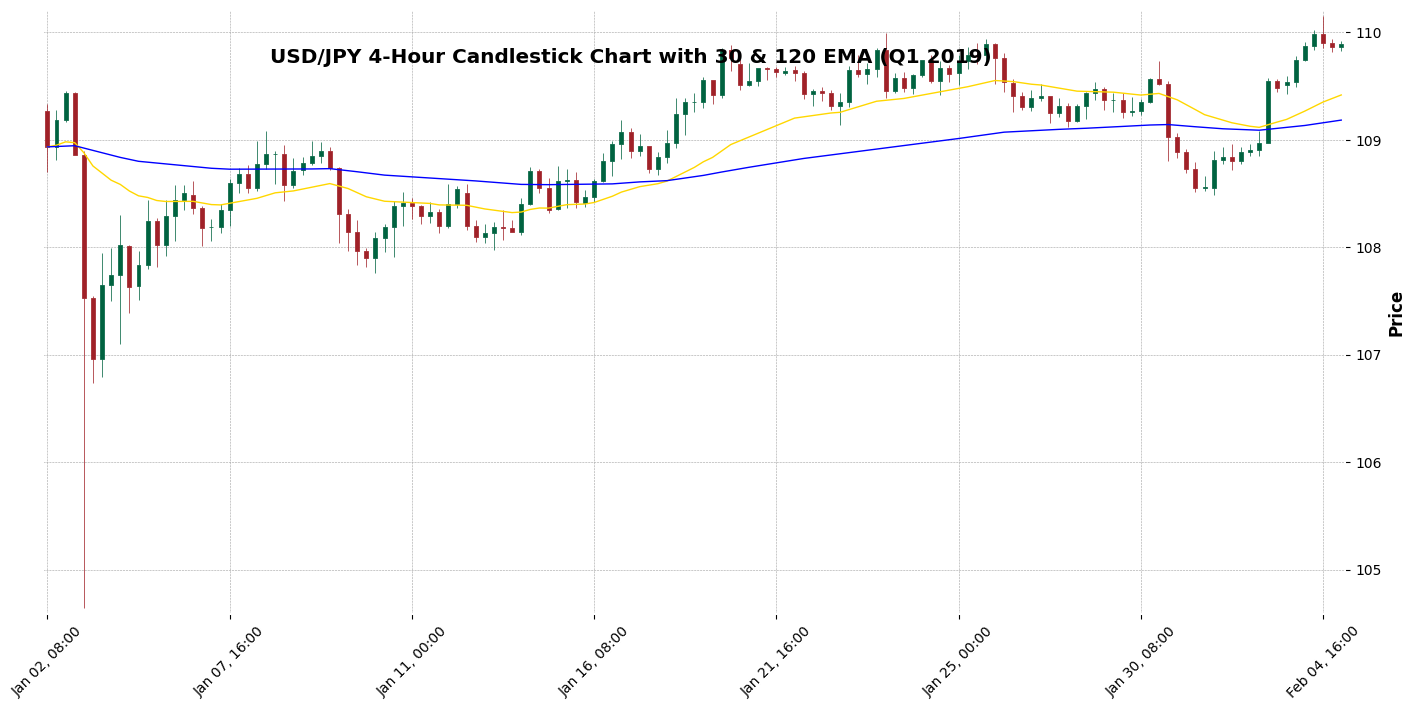

In [148]:
import pandas as pd
import mplfinance as mpf

# Filter 2019 Q1 using datetime index
df_2019_q1 = df[(df.index >= '2019-01-01') & (df.index <= '2019-02-05')].copy()

# Resample to 4-hour intervals
df_4h = df_2019_q1.resample('4H').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'TICKVOL': 'sum',
    'VOL': 'sum',
    'SPREAD': 'mean'
}).dropna()

# Calculate 30 and 120 period EMAs on 'Close'
df_4h['EMA_30'] = df_4h['Close'].ewm(span=30, adjust=False).mean()
df_4h['EMA_120'] = df_4h['Close'].ewm(span=120, adjust=False).mean()

# Plot candlestick chart with EMAs
mpf.plot(df_4h[['Open', 'High', 'Low', 'Close']],
         type='candle',
         style='charles',
         title='USD/JPY 4-Hour Candlestick Chart with 30 & 120 EMA (Q1 2019)',
         ylabel='Price',
         volume=False,
         figsize=(15, 7),
         tight_layout=True,
         addplot=[
             mpf.make_addplot(df_4h['EMA_30'], color='gold', width=1),
             mpf.make_addplot(df_4h['EMA_120'], color='blue', width=1)
         ])


##### Detect peak / trough

In [149]:
print(df_4h)

                        Open     High      Low    Close  TICKVOL  VOL  SPREAD  \
DATETIME                                                                        
2019-01-02 08:00:00  109.270  109.338  108.700  108.935    16815    0    15.0   
2019-01-02 12:00:00  108.935  109.278  108.813  109.181    20156    0    15.0   
2019-01-02 16:00:00  109.181  109.456  109.168  109.435    21792    0    15.0   
2019-01-02 20:00:00  109.435  109.448  108.856  108.864    14965    0    15.0   
2019-01-03 00:00:00  108.864  108.893  104.642  107.529    28704    0    15.0   
...                      ...      ...      ...      ...      ...  ...     ...   
2019-02-04 08:00:00  109.743  109.914  109.731  109.873     7730    0    15.0   
2019-02-04 12:00:00  109.873  110.019  109.837  109.989     7150    0    15.0   
2019-02-04 16:00:00  109.989  110.155  109.856  109.899    12230    0    15.0   
2019-02-04 20:00:00  109.899  109.937  109.822  109.864     4591    0    15.0   
2019-02-05 00:00:00  109.864

In [150]:
import pandas as pd

prices = df_4h['Close'].values
dates = df_4h.index.values

inflexion_dates = []
inflexion_prices = []
points = []

if len(prices) < 3:
    print("Not enough data for inflection points.")
else:
    for i in range(1, len(prices) - 1):
        prev_price = prices[i - 1]
        curr_price = prices[i]
        next_price = prices[i + 1]

        if curr_price > prev_price and curr_price > next_price:
            inflexion_dates.append(dates[i])
            inflexion_prices.append(curr_price)
            points.append('high')
        elif curr_price < prev_price and curr_price < next_price:
            inflexion_dates.append(dates[i])
            inflexion_prices.append(curr_price)
            points.append('low')

# Create the series for inflection point labels
point_series = pd.Series(points, index=inflexion_dates, name='point')

# Assign it to df_4h, aligning by index (datetime)
df_4h['point'] = point_series.reindex(df_4h.index)

In [151]:

print(type(df_4h.index[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [152]:
print(df_4h)

                        Open     High      Low    Close  TICKVOL  VOL  SPREAD  \
DATETIME                                                                        
2019-01-02 08:00:00  109.270  109.338  108.700  108.935    16815    0    15.0   
2019-01-02 12:00:00  108.935  109.278  108.813  109.181    20156    0    15.0   
2019-01-02 16:00:00  109.181  109.456  109.168  109.435    21792    0    15.0   
2019-01-02 20:00:00  109.435  109.448  108.856  108.864    14965    0    15.0   
2019-01-03 00:00:00  108.864  108.893  104.642  107.529    28704    0    15.0   
...                      ...      ...      ...      ...      ...  ...     ...   
2019-02-04 08:00:00  109.743  109.914  109.731  109.873     7730    0    15.0   
2019-02-04 12:00:00  109.873  110.019  109.837  109.989     7150    0    15.0   
2019-02-04 16:00:00  109.989  110.155  109.856  109.899    12230    0    15.0   
2019-02-04 20:00:00  109.899  109.937  109.822  109.864     4591    0    15.0   
2019-02-05 00:00:00  109.864

##### Visualize on peak and trough

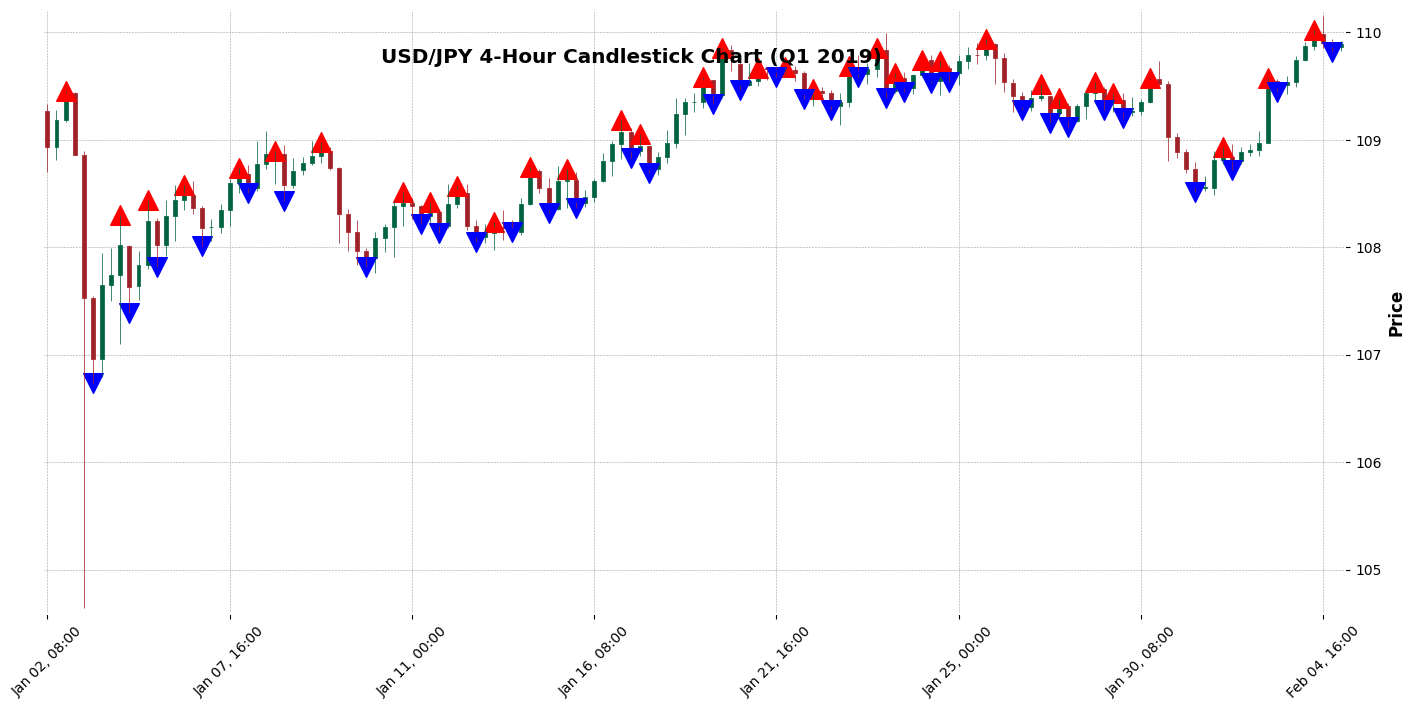

In [153]:
import pandas as pd
import numpy as np
import mplfinance as mpf

# Create series for highs and lows, NaN where not high/low
highs_reindexed = df_4h['High'].where(df_4h['point'] == 'high', np.nan)
lows_reindexed  = df_4h['Low'].where(df_4h['point'] == 'low', np.nan)

apds = []
if highs_reindexed.notna().any():
    apds.append(mpf.make_addplot(
        highs_reindexed,
        type='scatter',
        markersize=200,
        marker='^',
        color='red',
        panel=0
    ))
if lows_reindexed.notna().any():
    apds.append(mpf.make_addplot(
        lows_reindexed,
        type='scatter',
        markersize=200,
        marker='v',
        color='blue',
        panel=0
    ))

mpf.plot(
    df_4h[['Open', 'High', 'Low', 'Close']],
    type='candle',
    style='charles',
    title='USD/JPY 4-Hour Candlestick Chart (Q1 2019)',
    ylabel='Price',
    volume=False,
    figsize=(15, 7),
    tight_layout=True,
    addplot=apds
)

##### HH, HL, LH, LL

In [154]:
df_4h['trend'] = np.nan
df_4h['label'] = np.nan
# df_4h = df_4h.drop(columns=['TICKVOL', 'VOL', 'SPREAD'])
print(df_4h.head())

                        Open     High      Low    Close  TICKVOL  VOL  SPREAD  \
DATETIME                                                                        
2019-01-02 08:00:00  109.270  109.338  108.700  108.935    16815    0    15.0   
2019-01-02 12:00:00  108.935  109.278  108.813  109.181    20156    0    15.0   
2019-01-02 16:00:00  109.181  109.456  109.168  109.435    21792    0    15.0   
2019-01-02 20:00:00  109.435  109.448  108.856  108.864    14965    0    15.0   
2019-01-03 00:00:00  108.864  108.893  104.642  107.529    28704    0    15.0   

                         EMA_30     EMA_120 point  trend  label  
DATETIME                                                         
2019-01-02 08:00:00  108.935000  108.935000   NaN    NaN    NaN  
2019-01-02 12:00:00  108.950871  108.939066   NaN    NaN    NaN  
2019-01-02 16:00:00  108.982105  108.947263  high    NaN    NaN  
2019-01-02 20:00:00  108.974485  108.945887   NaN    NaN    NaN  
2019-01-03 00:00:00  108.881228  108

In [165]:
import mplfinance as mpf

def plot_fibonacci_candlestick(df, start_idx, end_idx, levels=None):
    if levels is None:
        levels = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

    # Slice the dataframe using datetime-based index
    df_slice = df.iloc[start_idx:end_idx + 1].copy()

    # Calculate high and low for Fibonacci levels
    min_price = df_slice['Low'].min()
    max_price = df_slice['High'].max()

    # Prepare Fibonacci horizontal lines
    fib_lines = []
    for level in levels:
        y = max_price - (max_price - min_price) * level
        fib_lines.append(mpf.make_addplot(
            [y] * len(df_slice),  # repeat y to match the index size
            color='gray', linestyle='--', width=0.7
        ))

    # Add label markers (L, LL, LH)
    for label_type, color in zip(['L', 'LL', 'LH'], ['blue', 'red', 'green']):
        label_subset = df_slice[df_slice.get('label') == label_type]
        if not label_subset.empty:
            y_vals = label_subset['Low'] * 0.995
            y_vals.index = label_subset.index  # ensure proper datetime index
            fib_lines.append(
                mpf.make_addplot(
                    y_vals,
                    type='scatter',
                    markersize=100,
                    marker='v',
                    color=color
                )
            )

    # Plot with mplfinance
    mpf.plot(df_slice,
             type='candle',
             style='yahoo',
             addplot=fib_lines,
             title='Fibonacci Retracement with L, LL, LH Labels',
             ylabel='Price',
             volume=False)


In [156]:
print(df.index)

DatetimeIndex(['2010-01-04 00:00:00', '2010-01-04 01:00:00',
               '2010-01-04 02:00:00', '2010-01-04 03:00:00',
               '2010-01-04 04:00:00', '2010-01-04 05:00:00',
               '2010-01-04 06:00:00', '2010-01-04 07:00:00',
               '2010-01-04 08:00:00', '2010-01-04 09:00:00',
               ...
               '2020-12-31 09:00:00', '2020-12-31 10:00:00',
               '2020-12-31 11:00:00', '2020-12-31 12:00:00',
               '2020-12-31 13:00:00', '2020-12-31 14:00:00',
               '2020-12-31 15:00:00', '2020-12-31 16:00:00',
               '2020-12-31 17:00:00', '2020-12-31 18:00:00'],
              dtype='datetime64[ns]', name='DATETIME', length=68155, freq=None)


30


ValueError: x and y must be the same size

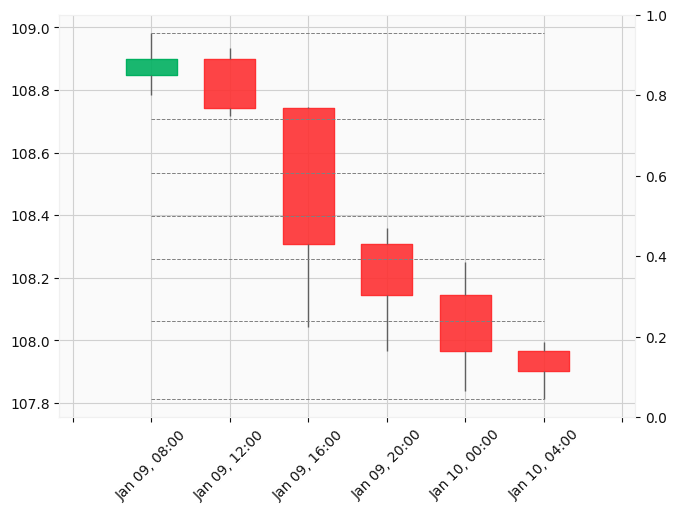

In [166]:
last_high = None
last_high_idx = None
last_low = None

if 'label' not in df_4h.columns:
    df_4h['label'] = np.nan
if 'trend' not in df_4h.columns:
    df_4h['trend'] = np.nan


# Loop through the DataFrame starting from a safe index
for idx in range(len(df_4h)):
    
    ema_30 = df_4h["EMA_30"].iloc[idx]
    ema_120 = df_4h["EMA_120"].iloc[idx]

    # Skip if either EMA is NaN (early rows)
    if np.isnan(ema_30) or np.isnan(ema_120):
        continue

    if ema_30 > ema_120:
        current_trend = "bullish"

    elif ema_30 < ema_120:
        current_trend = "bearish"
        
    else:
        # Handle the case when they are equal
        if idx == 0 or pd.isna(df_4h["trend"].iloc[idx-1]):
            continue  # not enough history to determine trend change
        previous_trend = df_4h["trend"].iloc[idx-1]
        current_trend = "bearish" if previous_trend == "bullish" else "bullish"
    
    current_point = df_4h["point"].iloc[idx]
    current_price = df_4h["Close"].iloc[idx]

    if current_trend == "bullish":
        pass  # You might want to implement bullish logic later
    
    elif current_trend == "bearish":
        if current_point == "low":
            if last_low is None:
                df_4h.loc[df_4h.index[idx], 'label'] = "L"
                last_low = current_price
            else:
                if current_price < last_low:
                    df_4h.loc[df_4h.index[idx], 'label'] = "LL"
                    print(last_high_idx)
                    plot_fibonacci_candlestick(df_4h, start_idx=last_high_idx, end_idx=idx)
                    df_4h.loc[df_4h.index[last_high_idx], 'label'] = "LH"
                    last_low = current_price
                else:
                    last_low = current_price

        elif current_point == "high":
            last_high = current_price
            last_high_idx = idx
            if last_high is None:
                df_4h.loc[df_4h.index[idx], 'label'] = "H"

    df_4h.loc[df_4h.index[idx], 'trend'] = current_trend